In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, label_binarize
from sklearn.svm import SVC, SVR
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,  matthews_corrcoef, confusion_matrix, r2_score,  mean_squared_error, mean_absolute_error, roc_curve,  auc, roc_auc_score)
from xgboost import XGBClassifier
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.decomposition import PCA
from scipy import stats


In [2]:
df=pd.read_csv('cardio_train.csv',sep=";")
df

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,99993,19240,2,168,76.0,120,80,1,1,1,0,1,0
69996,99995,22601,1,158,126.0,140,90,2,2,0,0,1,1
69997,99996,19066,2,183,105.0,180,90,3,1,0,1,0,1
69998,99998,22431,1,163,72.0,135,80,1,2,0,0,0,1


In [3]:
df['age']=(df['age']/365.25).round()
df

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,50.0,2,168,62.0,110,80,1,1,0,0,1,0
1,1,55.0,1,156,85.0,140,90,3,1,0,0,1,1
2,2,52.0,1,165,64.0,130,70,3,1,0,0,0,1
3,3,48.0,2,169,82.0,150,100,1,1,0,0,1,1
4,4,48.0,1,156,56.0,100,60,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,99993,53.0,2,168,76.0,120,80,1,1,1,0,1,0
69996,99995,62.0,1,158,126.0,140,90,2,2,0,0,1,1
69997,99996,52.0,2,183,105.0,180,90,3,1,0,1,0,1
69998,99998,61.0,1,163,72.0,135,80,1,2,0,0,0,1


In [4]:
if 'id' in df.columns:
    df.drop(columns=['id'], inplace=True)

# Feature Engineering

In [5]:
df['bmi'] = df['weight'] / ((df['height']/100)**2)
df = df[(df['bmi'] >= 15) & (df['bmi'] <= 50)]

In [6]:
df['pulse_pressure'] = df['ap_hi'] - df['ap_lo']
df['hypertension'] = ((df['ap_hi'] >= 140) | (df['ap_lo'] >= 90)).astype(int)
df['obesity'] = (df['bmi'] >= 30).astype(int)

df = df.drop(columns=['height', 'weight', 'ap_hi', 'ap_lo'])


<ipython-input-6-d805715d4f7b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pulse_pressure'] = df['ap_hi'] - df['ap_lo']
<ipython-input-6-d805715d4f7b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hypertension'] = ((df['ap_hi'] >= 140) | (df['ap_lo'] >= 90)).astype(int)
<ipython-input-6-d805715d4f7b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

In [7]:
X = df.drop('cardio', axis=1)
y = df['cardio']
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ensemble model

In [8]:
C1 = GaussianNB()
C2 = RandomForestClassifier(n_estimators=100, random_state=42)
C3 = SVC(probability=True, random_state=42)
C4 = GradientBoostingClassifier(n_estimators=100, random_state=42)

In [9]:
# soft voting ensemble model
soft_voting_classifier = VotingClassifier(
    estimators=[('Naive Bayes', C1), ('Random Forest', C2), ('SVM', C3), ('Gradient Boosting', C4)],
    voting='soft' )

In [10]:
soft_voting_classifier.fit(x_train, y_train)

predictions = soft_voting_classifier.predict(x_test)

In [11]:
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy of the ensemble model: {accuracy * 100:.2f}%")

Accuracy of the ensemble model: 72.77%


In [12]:
classifiers = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "XGBoost": XGBClassifier(eval_metric='logloss', random_state=42),
    "Random Forest": C2,
    "Support Vector Machine": C3,
    "Naive Bayes": C1,
    "Gradient Boosting": C4,
    "Proposed Ensemble model": soft_voting_classifier
}

In [13]:
metrics = {
    "Accuracy": [],
    "Sensitivity": [],
    "Specificity": [],
    "Precision": [],
    "Recall": [],
    "F1-Score": [],
    "MCC": [] }

In [14]:

# eval. each classifier
for name, model in classifiers.items():
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    metrics["Accuracy"].append(accuracy_score(y_test, y_pred))
    metrics["Sensitivity"].append(recall_score(y_test, y_pred))
    metrics["Specificity"].append(tn / (tn + fp))
    metrics["Precision"].append(precision_score(y_test, y_pred))
    metrics["Recall"].append(recall_score(y_test, y_pred))
    metrics["F1-Score"].append(f1_score(y_test, y_pred))
    metrics["MCC"].append(matthews_corrcoef(y_test, y_pred))


In [15]:
# show plotted graph

bar_width = 0.1
index = np.arange(len(metrics))
plt.figure(figsize=(14, 6))
colors = ['lightgray', 'green', 'darkgray', 'gold', 'blue', 'deepskyblue', 'brown', 'olive']

<Figure size 1400x600 with 0 Axes>

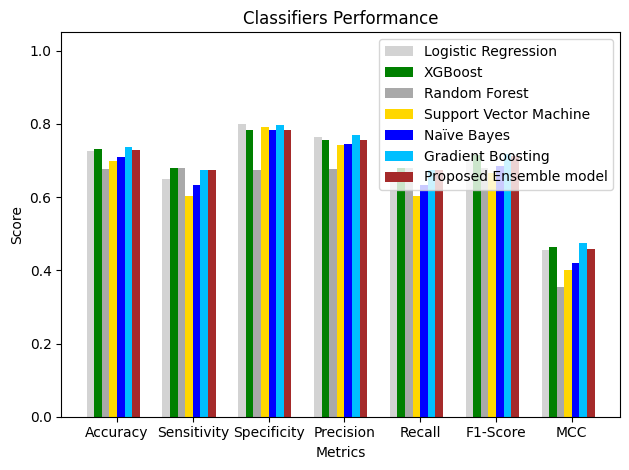

In [16]:
for i, (name, color) in enumerate(zip(classifiers.keys(), colors)):
    values = [metrics[metric][i] for metric in metrics]
    plt.bar(index + i * bar_width, values, bar_width, label=name, color=color)

plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('Classifiers Performance')
plt.xticks(index + bar_width * 3.5, metrics.keys())
plt.ylim(0, 1.05)
plt.legend()
plt.tight_layout()
plt.show()

In [17]:
# binarize the labels for multiclass or binary format
y_test_bin = label_binarize(y_test, classes=[0, 1]).ravel()

In [18]:

# dict. of classifiers
classifiers = {
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "XGBoost": XGBClassifier(eval_metric='logloss', random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Support Vector Machine": SVC(probability=True, random_state=42),
    "Naive Bayes": GaussianNB(),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, random_state=42),
    "Proposed Ensemble Model": VotingClassifier(
        estimators=[
            ('Naive Bayes', GaussianNB()),
            ('Random Forest', RandomForestClassifier(n_estimators=100, random_state=42)),
            ('SVM', SVC(probability=True, random_state=42)),
            ('Gradient Boosting', GradientBoostingClassifier(n_estimators=100, random_state=42)) ],

        voting='soft' )
}

In [ ]:
# Plot setup
plt.figure(figsize=(10, 6))

# Generate ROC for each classifier
for name, clf in classifiers.items():
    clf.fit(x_train, y_train)
    if hasattr(clf, "predict_proba"):
        y_proba = clf.predict_proba(x_test)[:, 1]
    else:
        y_proba = clf.decision_function(x_test)

    fpr, tpr, _ = roc_curve(y_test_bin, y_proba)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")
# dashed diag. line for random guess
plt.plot([0, 1], [0, 1], 'k--', linewidth=0.8)


plt.xlabel("FP rate - (1 - specificity)")
plt.ylabel("TP rate - (Sensitivity)")
plt.title("ROC of models")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# logistic reg.

In [21]:
# split data 9:10 as it is best
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

model = LogisticRegression(solver='liblinear')
model.fit(X_train, y_train)
predictions = model.predict(X_test)

NameError: name 'x' is not defined

In [ ]:
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy of LR model: {accuracy * 100:.2f}%")

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42
)

logreg = LogisticRegression(max_iter=1000, random_state=42)
logreg.fit(x_train, y_train)


In [ ]:
y_prob = logreg.predict_proba(X_test)[:, 1]

# binarize labels to make sure if not binary
y_test_bin = label_binarize(y_test, classes=[0, 1]).ravel()


In [ ]:
# calc. ROC and AUC
fpr, tpr, _ = roc_curve(y_test_bin, y_prob)
roc_auc = roc_auc_score(y_test_bin, y_prob)


In [ ]:
#ROC curve
plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], 'k--') #DASH LINE
plt.title("LR ROC Curve")
plt.xlabel("FP rate")
plt.ylabel("TP rate")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()